# Import libraries

In [4]:
import pandas as pd
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
    Dropout,
    Input, 
    Concatenate,
    GlobalAveragePooling2D, 
    GlobalMaxPooling2D,
)
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input
from tensorflow import Tensor
from scipy.stats import mannwhitneyu
from tabulate import tabulate

!pip3 install progressbar
import progressbar

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)

# Image Read and Resize Function

In [5]:
def load_raw_data():
    covid_path = "C:/Users/joest/OneDrive/Desktop/MINI-Project/transfer-learning-covid-19-vgg19/2COVID"
    non_covid_path = "C:/Users/joest/OneDrive/Desktop/MINI-Project/transfer-learning-covid-19-vgg19/1NonCOVID"
    cap_path = "C:/Users/joest/OneDrive/Desktop/MINI-Project/transfer-learning-covid-19-vgg19/3CAP"

    covid_images = list(Path(covid_path).glob("*.png"))
    non_covid_images = list(Path(non_covid_path).glob("*.png"))
    cap_images = list(Path(cap_path).glob("*.png"))
    
    # To visualize the dataset
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    image = img.imread(covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Covid Affected Lungs")

    fig.add_subplot(1, 2, 2)
    image = img.imread(non_covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Healthy Lungs")
    return covid_images, non_covid_images, cap_images


7593
6893
2618


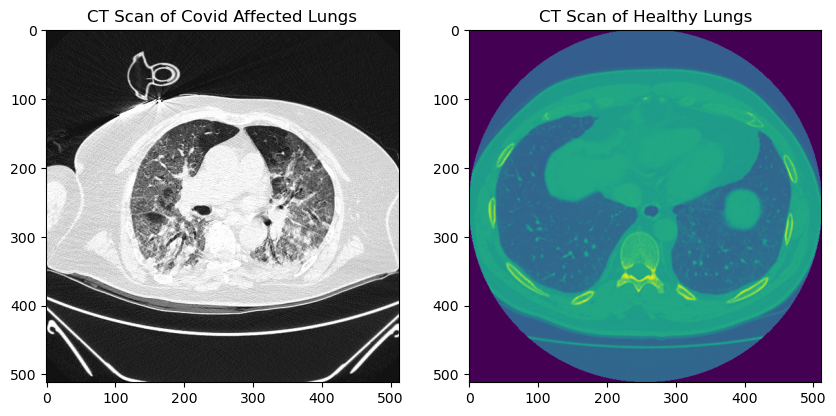

In [6]:
covid_images, non_covid_images, cap_images = load_raw_data()

print(len(covid_images))
print(len(non_covid_images))
print(len(cap_images))

In [7]:
IMG_SIZE = 64

# Three empty numpy arrays to store coverted images
positive_npy = np.empty((len(covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
negative_npy = np.empty((len(non_covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
cap_npy = np.empty((len(cap_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# start a bar of show percentage of loading data 
covid_bar = progressbar.ProgressBar(maxval=len(covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
non_covid_bar = progressbar.ProgressBar(maxval=len(non_covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
cap_bar = progressbar.ProgressBar(maxval=len(cap_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])


In [8]:
covid_bar.start()
# Converting COVID dataset to .npy format
for i, _file in enumerate(covid_images):
    try:
        image_npy = img.imread(_file)
        positive = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        positive_npy[i] = positive
    except:
        pass
    covid_bar.update(i+1)
    
covid_bar.finish()
print("COVID images converting done")

COVID images converting done


In [9]:
non_covid_bar.start()
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(non_covid_images):
    try:
        image_npy = img.imread(_file)
        negative = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        negative_npy[i] = negative
    except:
        print("cant open image " + i + "th") 
        
    non_covid_bar.update(i+1)
non_covid_bar.finish()
print("non covid images converting done")     

non covid images converting done


In [10]:
cap_bar.start()
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(cap_images):
    try:
        image_npy = img.imread(_file)
        cap = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        cap_npy[i] = cap
    except:
        print("cant open image " + i + "th") 
        
    cap_bar.update(i+1)
cap_bar.finish()
print("cap images converting done") 

cap images converting done


In [11]:
print(positive_npy.shape)
print(negative_npy.shape)
print(cap_npy.shape)

(7593, 64, 64, 1)
(6893, 64, 64, 1)
(2618, 64, 64, 1)


In [13]:
# To load .npy datasets
def load_data():
    global positive_npy, negative_npy, cap_npy
    cap = cap_npy
    cap_labels = [2 for i in cap]
    positive = positive_npy
    positive_labels = [1 for i in positive]
    negative = negative_npy
    negative_labels = [0 for i in negative]

    # Joining both datasets and labels
    X = np.concatenate([positive, negative, cap])
    y = np.concatenate([negative_labels, positive_labels, cap_labels])
    return X, y

In [14]:
# save x and y
X, y = load_data()
np.savez('X', X)
np.savez('y', y)

In [15]:
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_hot = keras.utils.to_categorical(y_train, 3)
y_test_hot =  keras.utils.to_categorical(y_test, 3)

(17104, 64, 64, 1)
(17104,)


# VGG Layers

In [16]:
VGG = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
VGG.trainable =False #last fully connected layersz are not included
for i, layer in enumerate(VGG.layers):
  print(i, layer.name)

for layer in VGG.layers[:-5]:
   layer.trainable = False
for layer in VGG.layers[-5:]:
   layer.trainable = True
for layer in VGG.layers:
    print(layer, layer.trainable) 
#The last 5 layers (block5_conv1, block5_conv2, block5_conv3, block5_conv4, block5_pool) 
#are set to trainable, allowing the model to fine-tune these layers during training
VGG.summary()

0 input_layer
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<Conv2D name=block3_conv4, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=blo

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

# VGG19 Freeze Last Block

In [17]:
def cnn(): 
    from tensorflow.keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
    from tensorflow.keras.models import Model
    VGG = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    for layer in VGG.layers[:-5]:
      layer.trainable = False
    for layer in VGG.layers[-5:]:
      layer.trainable = True
    
    input = Input(shape=(64, 64, 1))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = VGG(x , training=False)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3, activation="softmax", name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Data Augmentation and Fitting Model

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def cnn():
    # Define the input layer with a shape that matches your image dimensions
    input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    
    # Add a series of convolutional and pooling layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Flatten the output from the convolutional layers before passing it to the Dense layers
    x = Flatten()(x)
    
    # Add a fully connected layer
    x = Dense(128, activation='relu')(x)
    
    # Add a dropout layer for regularization
    x = Dropout(0.5)(x)
    
    # Define the output layer with softmax activation (assuming multi-class classification)
    output_layer = Dense(3, activation='softmax')(x)  # 3 classes for example
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model using Adam optimizer
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Call the model and display the summary
model = cnn()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,141,763 (4.36 MB)

 Trainable params: 1,141,763 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.keras', verbose=1, save_best_only=True)

# Ensure BATCH_SIZE is defined
BATCH_SIZE = 64

# Training the model
history = model.fit(X_train, y_train_hot, 
                    batch_size=BATCH_SIZE,
                    epochs=200,
                    verbose=1,
                    callbacks=[annealer, checkpoint],
                    validation_data=(X_test, y_test_hot))


Epoch 1/200
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9904 - loss: 0.0236
Epoch 1: val_loss improved from inf to 0.05756, saving model to model.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.9904 - loss: 0.0236 - val_accuracy: 0.9871 - val_loss: 0.0576 - learning_rate: 0.0010
Epoch 2/200
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9879 - loss: 0.0278
Epoch 2: val_loss improved from 0.05756 to 0.05460, saving model to model.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.9879 - loss: 0.0278 - val_accuracy: 0.9877 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 3/200
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9899 - loss: 0.0246
Epoch 3: val_loss did not improve from 0.05460
214/214 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.9899 - loss: 0.0246 - val_accuracy: 0.9880 - val_loss: 0.0571 - learning_rate: 0.0010
Epoch 4/200
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9916 - loss: 0.0243
Epoch 4: val

# Accuracy and Loss Curve

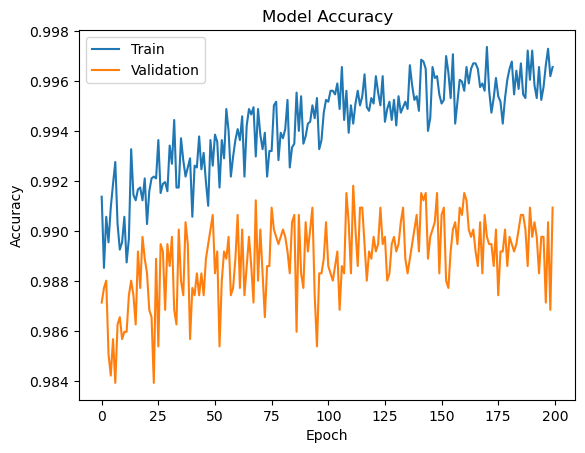

In [26]:
import matplotlib.pyplot as plt

# Assuming history is the object returned from model.fit()
# For example:
# history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10)

# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


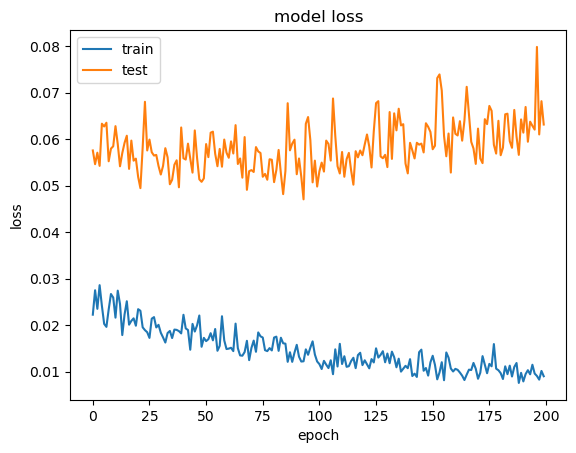

In [22]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# for plot images and lable them in form of model prediction and the actual that it was
def plot_image(i, predictions_array, true_labels, images):
    class_names = ['NON-COVID', 'COVID', 'PHENOMIA']
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% (real is:{})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('white')
    thisplot[true_label].set_color('black')

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
predicted = np.argmax(y_pred)
accuracy = np.equal(y_test, predicted).mean()
accuracy

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


0.0

# Plot images and label Predicted

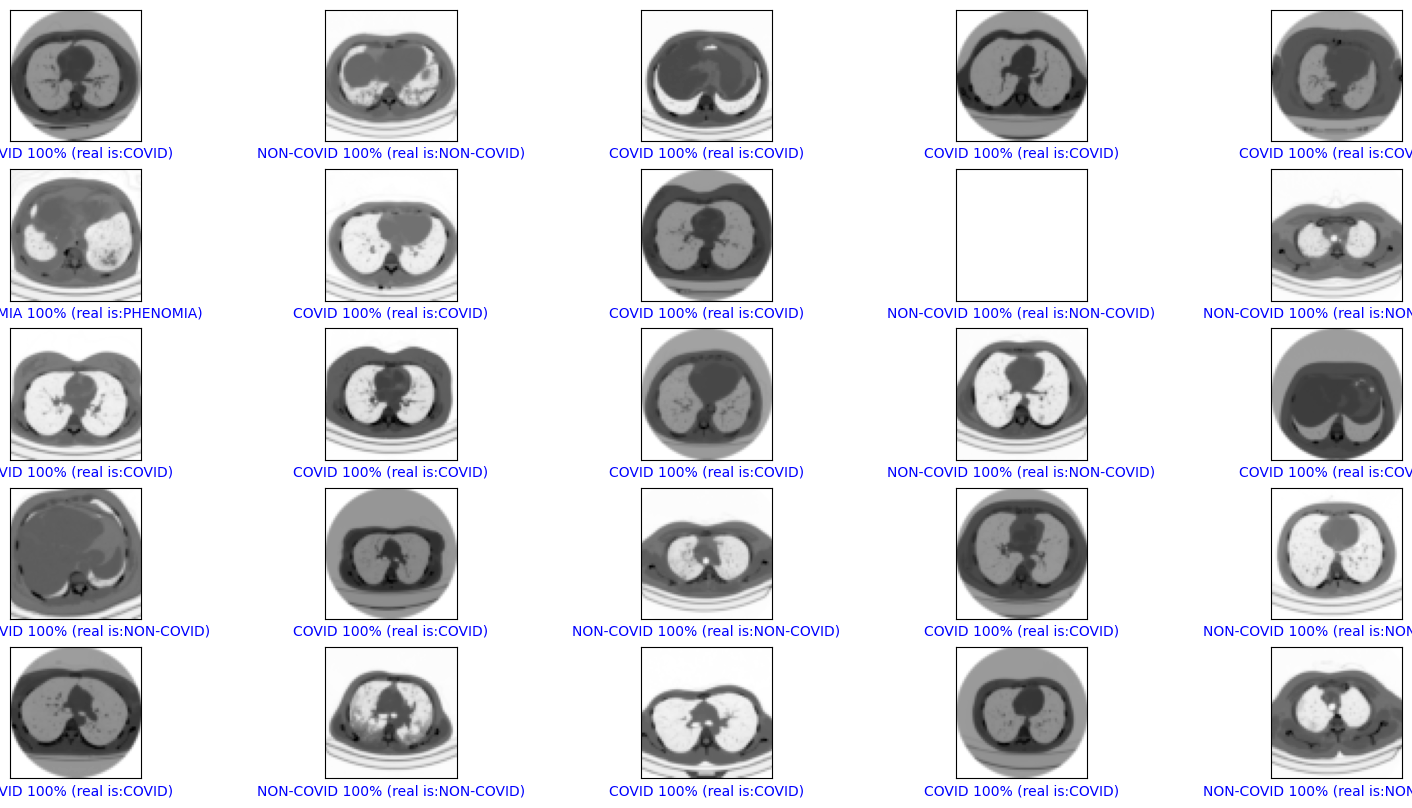

In [25]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_pred, y_test, X_test)